## IBSI Chapter 2 Phase 2 − Image filtering

@Author : [MEDomics consortium](https://github.com/medomics/)

@EMAIL : medomics.info@gmail.com

@REF : [IBSI 2](https://www.overleaf.com/read/hwhjswzkhwdh)

**STATEMENT**:
This file is part of <https://github.com/MEDomics/MEDomicsLab/>,
a package providing PYTHON programming tools for radiomics analysis.
--> Copyright (C) MEDomicsLab consortium.

### Introduction

We recommend to take a look at the [MEDscan-tutorial notebook](https://colab.research.google.com/github/MahdiAll99/MEDimage/blob/dev/notebooks/tutorial/MEDscan-Tutorial.ipynb) and the [DataManager-tutorial](https://colab.research.google.com/github/MahdiAll99/MEDimage/blob/dev/notebooks/tutorial/DataManager-Tutorial.ipynb) before running the IBSI tests.

The aim of this chapter and this phase is to extract filter-based radiomics features from the same CT-image mentionned in chapter 1. The methodology used to extract these values is described in [IBSI 2 benchmarking 5.2](https://www.overleaf.com/project/5da9e0b82f399f0001ad3970). As shows the figure below, the IBSI chapter 2 gives 2 configurations to test for image processing : configuration *A* and *B* and we will only test configuration *A* since *MEDimage Package* does not implement 2D feature computation.


<img src="images/ibsi2-p2-configurations.png" alt="Flowchart of radiomics study"/>


### Dataset - CT image
We use the same CT image as in IBSI 1 phase 2. The image can be found here: [ibsi_1_ct_radiomics_phantom](https://github.com/theibsi/data_sets/tree/master/ibsi_1_ct_radiomics_phantom)

In [1]:
import os
import sys

MODULE_DIR = os.path.dirname(os.path.abspath('../MEDimage/'))
sys.path.append(os.path.dirname(MODULE_DIR))

from copy import deepcopy
from pathlib import Path

import MEDimage

Comparison method to plot original data (pre-filtered data) and filtered data

In [2]:
def plot_comparison(result, original_data, slice_nb, test_id, filter_name):
    """
    Plot the coronal, axial and sagittal slices of the original image and the result image.
    :param result: The result obtained by the program.
    :param original_data: The original image
    :param slice_nb: Which slice will be plotted along each axis.
    :param test_id: The test identifier as string that will be used in the figure name. "Exemple: 2"
    :param filter_name: Name of the filter used.
    """
    import matplotlib.pyplot as plt

    if not filter_name:
        filter_name = 'no filter'
        
    if len(original_data.shape) > 3:
        original_data = np.squeeze(original_data)

    fig = plt.figure(figsize=(12, 12))
    fig.canvas.manager.set_window_title('Phase2_ID' + test_id + 'B')

    if original_data is not None:

        fig.suptitle(f'Original image vs Processed image using {filter_name}. (Test ID : {test_id}.B)', fontsize=16)

        fig.add_subplot(2, 3, 1, ylabel="Original image", title="Coronal")
        plt.imshow(original_data[:, :, slice_nb], cmap='gray')

        fig.add_subplot(2, 3, 2, title="Axial")
        plt.imshow(original_data[:, slice_nb, :], cmap='gray')

        fig.add_subplot(2, 3, 3, title="Sagittal")
        plt.imshow(original_data[slice_nb, :, :], cmap='gray')

        fig.add_subplot(2, 3, 4, ylabel="Result")
        plt.imshow(result[:, :, slice_nb], cmap='gray')

        fig.add_subplot(2, 3, 5)
        plt.imshow(result[:, slice_nb, :], cmap='gray')

        fig.add_subplot(2, 3, 6)
        plt.imshow(result[slice_nb, :, :], cmap='gray')

    else:
        fig.add_subplot(1, 3, 1, ylabel="Result")
        plt.imshow(result[0, :, :, slice_nb], cmap='gray')

        fig.add_subplot(1, 3, 2)
        plt.imshow(result[0, :, slice_nb, :], cmap='gray')

        fig.add_subplot(1, 3, 3)
        plt.imshow(result[0, slice_nb, :, :], cmap='gray')

    plt.show()

### Configuration

The first step in this notebook is choosing the test ID (Test to run). Since only configuration B is implemented, we don't specify the configuration in the test ID .i.e. instead of test ID *5.B* we use test ID *5* Test IDs accepted : *1* *2* *3* *4* *5* *6* and *7* (equivalent to *1.B* *2.B* *3.B* *4.B* *5.B* *6.B* and *7.B* in the IBSI). Filters and parameters for the configurations B (ҎD) defined in the following table (The filter parameters for config *B* are in the second row of each test ID):

<img src="images/ibsi2-p2-testids.png" alt="Flowchart of radiomics study"/>


In [3]:
test_id = '2' # test ID. More details about tests can be found in the IBSI chapter 2 reference

### Initialization

Before you start running the notebook, make sure you download the CT-image from [here](https://github.com/theibsi/data_sets/tree/master/ibsi_1_ct_radiomics_phantom/dicom) and organize your folder as shown in the figure below:

<img src="images/ibsi2-p2-folder-structure.png"/>


As seen before, we are going to use the ``MEDscan`` class and other processing classes like ``DataManager`` to process the iamging data and use other modules to extract the radiomics features. So we start by initializing the ``DataManager`` class and create a ``MEDscan`` instance from the CT image.

In [4]:
# Intialize the DataManager class
path_to_dicoms = Path(os.getcwd()) / "data" / "CTimage"
dm = MEDimage.wrangling.DataManager(path_to_dicoms=path_to_dicoms)

# Process the DICOM scan
MEDinstance = dm.process_all_dicoms()[0]  # one-element list/ one scan

2022-10-04 13:34:10,063	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8266


--> Reading all DICOM objects to create MEDscan classes

--> Scanning all folders in initial directory...

100%|██████████| 61/61 [00:00<00:00, 3269.64it/s]


DONE
--> Associating all RT objects to imaging volumes


100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


DONE
--> Processing DICOMs and creating MEDscan objects


100%|██████████| 1/1 [00:00<00:00, 6141.00it/s]

DONE


As mentioned before, CT-scan have a voxel spacing of 1 (value fixed by the IBSI) so it's gonna be our voxel length and will be used to compute the kernel size for some filter.

In [5]:
VOLEX_LENGTH = 1

### Image processing

Processing is done prior to image filtering. The processing steps are:
- Segmentation (Creation/Extraction of ROI mask)
- Interpolation :
    - resampled voxel spacing (mm) : [1 × 1 × 1]
    - interpolation method : tricubic spline
    - intensity rounding : nearest integer
    - ROI interpolation method : trilinear
    - ROI partial mask volume : 0.5
- Re-segmentation :
    - range(HU) : [-1000, 400]
- Image filtering
- ROI extraction

**PS**: We assume that the IBSI chapter 1 notebooks are tested and the image processing steps are now clear, so no more details are given here.

#### Segmentation

First, we extract the ROI mask (Images are already annotated and we just need to extract the ROI from the data in the class)

In [6]:
vol_obj_init, roi_obj_init = MEDimage.processing.segmentation.get_roi_from_indexes(MEDinstance,
                                                           name_roi='{GTV-1}',
                                                           box_string='full')

Initialize processing & computation parameters. This following part of the code is added to make it easy for users to test all filters without changing the JSON parameters every time and parameters are changed automatically.

In [7]:
path_settings = Path(os.getcwd()) / "settings" # Path to the script settings/configuration folder

# Load script parameters
im_params = MEDimage.utils.json_utils.load_json(path_settings / f'IBSI2Phase2B_settings.json')

filter_name = ''

if test_id == "1":
    filter_name = ''

elif test_id == "2":
    filter_name = 'mean'
    im_params['imParamCT']['filter_type'] = filter_name

elif test_id == "3":
    filter_name = 'log'
    im_params['imParamCT']['filter_type'] = filter_name

elif test_id == "4":
    filter_name = 'laws'
    im_params['imParamCT']['filter_type'] = filter_name

elif test_id == "5":
    filter_name = 'gabor'
    im_params['imParamCT']['filter_type'] = filter_name

elif test_id == "6":
    filter_name = 'Wavelet_db3_LLH'
    im_params['imParamCT']['filter_type'] = 'wavelet'
    im_params['imParamFilter']['wavelet']['subband'] = 'LLH'
    im_params['imParamFilter']['wavelet']['level'] = 1

elif test_id == "7":        
    filter_name = 'Wavelet_db3_HHH'
    im_params['imParamCT']['filter_type'] = 'wavelet'
    im_params['imParamFilter']['wavelet']['subband'] = 'HHH'
    im_params['imParamFilter']['wavelet']['level'] = 2

else:
    raise NotImplementedError
    
# Update params in class instance
MEDinstance.init_params(im_params)

#### Diagnostic features
The diagnostic features are computed before and after re-segmentation and interpolation to identify the issues with the implementation (if there is any).

##### Initial diagnostics

In [8]:
# Extract initial diagnostic featues
diag_init = MEDimage.biomarkers.diagnostics.extract_all(vol_obj_init, roi_obj_init, roi_obj_init, 'initial')

#### Interpolation

In [9]:
vol_obj = deepcopy(vol_obj_init)
roi_obj_morph = deepcopy(roi_obj_init)

# Intensity Mask
vol_obj = MEDimage.processing.interpolation.interp_volume(
    medscan=MEDinstance,
    vol_obj_s=vol_obj_init,
    image_type='image',
    roi_obj_s=roi_obj_init,
    box_string='full'
)
# Morphological Mask
roi_obj_morph = MEDimage.processing.interpolation.interp_volume(
    medscan=MEDinstance,
    vol_obj_s=roi_obj_init,
    image_type='roi', 
    roi_obj_s=roi_obj_init,
    box_string='full'
)

We compare voxel spacing before and after interpolation

In [10]:
# voxel spacing before interpolation
print('Before interp:', vol_obj_init.spatialRef.PixelExtentInWorldX, 
      vol_obj_init.spatialRef.PixelExtentInWorldY,
      vol_obj_init.spatialRef.PixelExtentInWorldZ)
# voxel spacing after interpolation
print('After interp:',vol_obj.spatialRef.PixelExtentInWorldX, 
      vol_obj.spatialRef.PixelExtentInWorldY,
      vol_obj.spatialRef.PixelExtentInWorldZ)
# Desired voxel spacing 
print('Desired voxel spacing is [1, 1, 1]')

Before interp: 0.977 0.977 3.0
After interp: 1 1 1
Desired voxel spacing is [1, 1, 1]


#### Re-segmentation

In [11]:
# Intensity mask re-segmentation
# range re-segmentation
roi_obj_int = deepcopy(roi_obj_morph)

# outlier re-segmentation
roi_obj_int.data = MEDimage.processing.resegmentation.range_re_seg(
            vol=vol_obj.data, 
            roi=roi_obj_int.data,
            im_range=MEDinstance.params.process.im_range
        )

##### Post-processing diagnostics

In [12]:
# Post-resegmentation diagnostic features extraction:
diag_re_seg = MEDimage.biomarkers.diagnostics.extract_all(vol_obj, roi_obj_int, roi_obj_morph, 'reSeg')

### Image filtering

First, let's retrieve the filter name

In [13]:
filter_name = MEDinstance.params.filter.filter_type

Unlike the phase 1, we will use the *MEDimage* sub-module *filter* method ``apply_filter`` to filter the CT image. The method uses the same steps as in phase 1. 

The parameters needed are already in the ``MEDscan`` class instance.

In [14]:
vol_obj = MEDimage.filters.apply_filter(MEDinstance, vol_obj)

#### ROI-Extraction

In [15]:
vol_int_re = MEDimage.processing.roi_extract(
            vol=vol_obj.data, 
            roi=roi_obj_int.data
        )

Initialization of all the computation parameters for NON-TEXTURE FEATURES. (we will only initialize non-texture-features)

In [16]:
# Preparation of computation:
MEDinstance.init_ntf_calculation(vol_obj)

#### Features computation

As mentioned in the IBSI, only part of the radiomics features standardized previously is gonna be computed which are : *statistical features* and *intensity histogram features*.

#### Intensity Histogram Features

In [17]:
int_hist = MEDimage.biomarkers.intensity_histogram.extract_all(vol=vol_int_re)

#### Intensity-based statistical features

In [18]:
stats = MEDimage.biomarkers.stats.extract_all(vol=vol_int_re)

Organize all the diagnostics specified by the IBSI for this phase (Only a part of the diagnostic features are checked in this phase).

In [19]:
diag_features = {
    'diag_n_voxel' : diag_init['roi_initial_Int_voxNumb'],
    'diag_n_voxel_interp_reseg' : diag_re_seg['roi_reSeg_Int_voxNumb'],
    'diag_mean_int_interp_reseg' : diag_re_seg['roi_reSeg_meanInt'],
    'diag_max_int_interp_reseg' : diag_re_seg['roi_reSeg_maxInt'],
    'diag_min_int_interp_reseg' : diag_re_seg['roi_reSeg_minInt']
    }

Print the features extraction results

In [20]:
from numpyencoder import NumpyEncoder
from json import dumps

print(dumps(
    {'Diagnostics' : diag_features, 
     'int_hist_3D' : int_hist, 
     'stats_3D' : stats}, 
    indent=4, 
    cls=NumpyEncoder)
     )

{
    "Diagnostics": {
        "diag_n_voxel": 125256,
        "diag_n_voxel_interp_reseg": 357802,
        "diag_mean_int_interp_reseg": -46.40788650512695,
        "diag_max_int_interp_reseg": 377.0,
        "diag_min_int_interp_reseg": -997.0
    },
    "int_hist_3D": {
        "Fih_mean": 0.016696385151564273,
        "Fih_var": 1.1257861611301094,
        "Fih_skew": 69.8707664048842,
        "Fih_kurt": 5276.7745049684845,
        "Fih_median": 37.336000000000084,
        "Fih_min": -906.1760000000002,
        "Fih_P10": -389.31520000000006,
        "Fih_P90": 77.24800000000005,
        "Fih_max": 316.3119999999999,
        "Fih_mode": 27,
        "Fih_iqr": 92.5839999999997,
        "Fih_range": 1222.488,
        "Fih_mad": 124.92883738453001,
        "Fih_rmad": 68.13315018252439,
        "Fih_medad": 113.8108796708794,
        "Fih_cov": -4.222954297040157,
        "Fih_qcod": 2.9727716414076353,
        "Fih_entropy": 0.004908175156972696,
        "Fih_uniformity": 2.15587489

Finally we plot the before-and-after image filtering

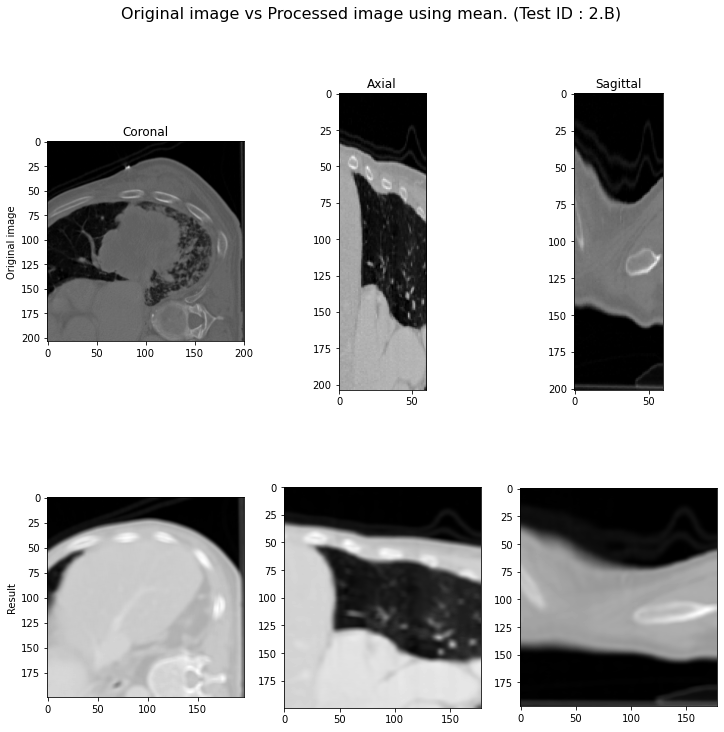

In [21]:
slice_nb = 31
plot_comparison(vol_obj.data, vol_obj_init.data, slice_nb=slice_nb, test_id=test_id, filter_name=filter_name)

The IBSI chapter 2 phase 2 features calculation results for *Udes* Team have been already submitted and can be found here : [Latest submissions](https://ibsi.radiomics.hevs.ch/#ibsi2-phase2-pane).